# Modeling seizure freedom (binary) using clinical data

## Import data

In [1]:
# Set to "most recent" for "most recent" approach
# Set to "closest to dos" for "closest to date of surgery" approach
approach = "closest to dos"

# Set to True for pre-surgical modalities in priority
# Set to False for smallest absolute difference between day of surgery and day of modality
pre_surgical = True

# Set to True for filtering below 5 years after-surgery
filtering = False

In [2]:
import pandas as pd

if (approach == "closest to dos") and pre_surgical:
    # Read dataframe
    wide_df = pd.read_csv("../../data/processed/preprocessed_ctd_pre.csv")

elif approach == "closest to dos":
    # Read dataframe
    wide_df = pd.read_csv("../../data/processed/preprocessed_ctd.csv")

else:
    # Read dataframe
    wide_df = pd.read_csv("../../data/processed/preprocessed_recent.csv")

# Read dataframe
# wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")

C:\Users\amaur\AppData\Local\Temp\ipykernel_19348\3326928528.py:5: DtypeWarning: Columns (80,122,145,312,316,320,324,380,458,507,518,519,520,521,522,523,524,561,567,583,584,585,586,587,596,597,599,600,603,615,616,617,622,628,631,632,634,641,677,690,693,707,709,713,715,716,718,720,721,723,727,728,730,743,745,752,754,756,757,759,763,765,767,769,771,786,805,807,808,809,810,812,813,882,883,891,900,963,970,971,979,988,1051,1058,1059,1067,1075,1076,1139,1146,1164,1227,1235,1252,1322,1323,1340,1411,1428,1518,1535,1553,1673,1725,1733,1785,1796,1814,1825,1877,1885,1948,1949,1958,1977,2029,2037,2089,2129,2181,2189,2241,2252,2253,2262,2281,2333,2341,2393,2405,2414,2422,2433,2485,2493,2545,2557,2585,2637,2645,2697,2726,2737,2789,2797,2849,2861,2878,2880,2881,2894,2898,2907,2912,2924,2946,2972,2973,3111,3123,3171,3239,3300,3473,3474,3483,3487,3490,3583,3584,3623,3635,3639,3647,3836,3839,3851,3855,3857,3858,3862,3867,3872,3881,3882,3965,3967,3972,3973,3976,3977,3978,3981,3990,3991,3992,3993,3994,399

In [3]:
# Function to clean surgeon names
def clean_surgeon_name(name):
    name = name.strip()
    name = name.replace(", MD", "")
    name = name.replace("Dr.", "")
    name = name.replace("MD", "")
    name = name.replace("Dr", "")
    name = name.strip()
    if "Werner Doyle" in name or "Werner K Doyle" in name:
        return "Werner Doyle"
    elif "Howard Weiner" in name:
        return "Howard Weiner"
    elif "Amanda Yaun" in name or "Amanda L Yaun" in name:
        return "Amanda Yaun"
    elif "David Hartner" in name or "David Harter" in name or "David H Hartner" in name:
        return "David Harter"
    elif "Douglas Kondziolka" in name or "Douglas S Kondziolka" in name:
        return "Douglas Kondziolka"
    elif "Unspecified" in name or "Not reported" in name:
        return "-"
    return name

## Select features

In [4]:
# wide_df["eo_date_clin_engel"] = pd.to_datetime(wide_df["eo_date_clin_engel"])
wide_df["resect_date"] = pd.to_datetime(
    wide_df["resect_date"], format="%m/%d/%Y", errors="coerce"
)

#BA_df = pd.read_csv("../../data/processed/BA.csv")
BA_df = pd.read_csv("../../data/processed/NYU_PyBrainAge_Output_20240716.csv")
BA_df = BA_df.rename(columns={"ID":"record_id",
                              "BrainPAD":"BA_pred"})

wide_df = pd.merge(wide_df, BA_df, on="record_id", how="left")
wide_df["presurg_scan_age"] = wide_df["presurg_scan_year"] - wide_df["dem_yob"]

#wide_df["BA_pred"] = wide_df["BA_pred"] - wide_df["presurg_scan_age"]

# Apply the cleaning function
wide_df['Cleaned_Surgeon'] = wide_df['resect_surgeon'].apply(clean_surgeon_name)

if filtering:
    # Selecting patients who had their surgeries less than 5 years before EO assessment
    #wide_df = wide_df[wide_df["eo_days_postsurg"] < (365.25 * 5)]
    wide_df = wide_df[(wide_df["eo_yrs_postsurg"]>=6.2)] # & (wide_df["eo_yrs_postsurg"]>=0.5)
    #wide_df = wide_df[(wide_df["eo_yrs_postsurg"]<6.2)]

X = wide_df[
    [
        "sex_gender",
        "resect_pt_age",
        "eeg",
        "engel_outcomes",
        "mri",
        "phys_findings",
        "age_of_onset_hw",
        "eo_days_postsurg",
        "neuroanatomical_labeling",
        "neuropsychological_testing",
        "surg_stage",
        "neuro_findings",
        "eo_year_surg",
        "surgical_information",
        "freq_per_month_hw",
        "resect_procedure___1",
        "resect_procedure___2",
        "resect_procedure___3",
        "resect_procedure___4",
        "resect_procedure___5",
        "resect_procedure___6",
        "resect_procedure___7",
        "resect_procedure___8",
        "resect_procedure___9",
        "resect_procedure___10",
        "resect_procedure___11",
        "resect_procedure___12",
        "resect_procedure___13",
        "resect_procedure___14",
        "resect_procedure___15",
        "seizure_notes_word_cnt",
        "date_diff_eeg",
        "date_diff_neuropsychological_testing",
        "date_diff_mri",
        "presurg_scan_age",
        "BA_pred",
        "Cleaned_Surgeon"
    ]
]

epilepsy_diagnosis = [
    "epi_dx_category",
    "epi_seiz_symp_idio",
    "epi_seiz_med_refract",
    "epi_seiz_se",
    "epi_icd",
    "epi_dx",
]  # "epi_dx" and "epi_key_information" for term frequency // Hot-encode the rest

past_medical_history = [
    "pmh_allergies",
    "pmh_non_aeds",
    "pmh_explanation",
    "pmh_dev_delay",
]  # "pmh_surg" // all except pmh_dev_delay for term frequency

seizure_classification = [
    "seiz_onset_lat",
    "seiz_onset_zone___1",
    "seiz_onset_zone___2",
    "seiz_onset_zone___3",
    "seiz_onset_zone___4",
    "seiz_onset_zone___5",
    "seizure_class___1",
    "seizure_class___2",
    "seizure_class___3",
    "seizure_class___4",
]  # Categorize or tf "seiz_onset_zone_oth" // One-Hot encode "seiz_onset_lat"

aed_history = ["prev_aeds", "prev_aeds_num"] + [
    f"prev_aeds_name___{i}" for i in range(1, 40)
]  # One-hot encode "prev_aeds" // "prev_aeds_num" is continuous (scaling)

# Select the handwritten columns as final columns (manually checked and annotated)
X = X.rename(
    columns={"age_of_onset_hw": "age_of_onset", "freq_per_month_hw": "freq_per_month"}
)

X = pd.concat([X, wide_df[seizure_classification]], axis=1)

# Fill NaN values with an empty string
#X["epi_dx"] = X["epi_dx"].fillna("")

y = wide_df["surg_engel"]

# Turns the outcome variable from range [1,4] to [0,3]
y = y - 1

del epilepsy_diagnosis, past_medical_history, seizure_classification, aed_history

## One-hot encoding

One-hot encode the new columns from Epilepsy diagnosis information

In [5]:
# One-Hot Encoding for the first four columns
X = pd.get_dummies(
    X,
    columns=[
        "surg_stage",
        "seiz_onset_lat",
        "Cleaned_Surgeon"
    ],
)  # , "prev_aeds"

## Correlation matrix

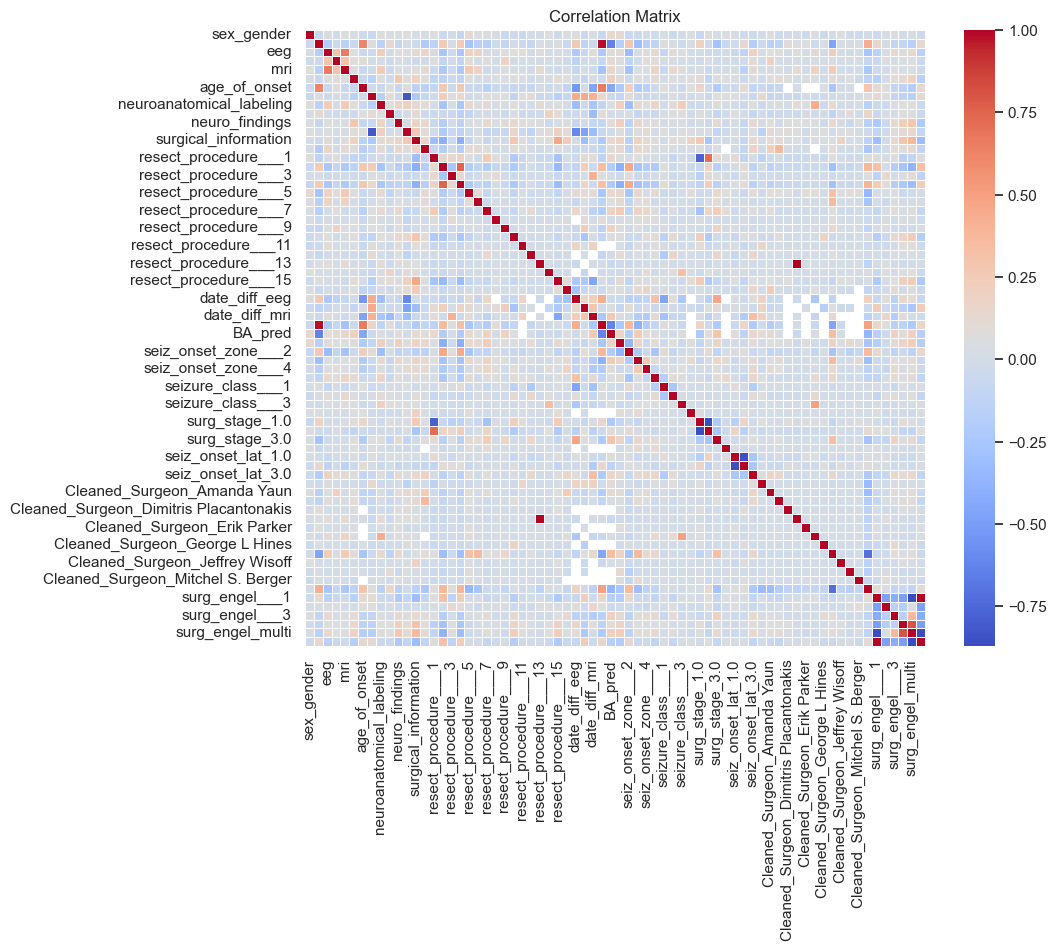

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

engel = wide_df[
    [
        "surg_engel___1",
        "surg_engel___2",
        "surg_engel___3",
        "surg_engel___4",
        "surg_engel",
    ]
]
engel = engel.rename(columns={"surg_engel": "surg_engel_multi"})
y2 = y == 0
engel = pd.concat([engel, y2], axis=1)

# Calculate the correlation matrix
correlation_matrix = pd.concat([X, engel], axis=1).corr()

# Create a heatmap using seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Check for high correlation variables

In [7]:
# Set a threshold for high correlation (e.g., 0.8 for 80%)
threshold = 0.8

# Find pairs of variables with a very high correlation
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_correlation_pairs.append(
                (correlation_matrix.columns[i], correlation_matrix.columns[j])
            )

# Print the pairs of variables with a very high correlation
print(f"Pairs of variables with correlation above {threshold}:")
for pair in high_correlation_pairs:
    print(pair)

del correlation_matrix, threshold, high_correlation_pairs, pair, i, j

Pairs of variables with correlation above 0.8:
('resect_pt_age', 'presurg_scan_age')
('eo_days_postsurg', 'eo_year_surg')
('resect_procedure___13', 'Cleaned_Surgeon_Douglas Kondziolka')
('surg_stage_1.0', 'surg_stage_2.0')
('seiz_onset_lat_1.0', 'seiz_onset_lat_2.0')
('surg_engel___1', 'surg_engel_multi')
('surg_engel___1', 'surg_engel')
('surg_engel___4', 'surg_engel_multi')
('surg_engel_multi', 'surg_engel')


### Check that the Binary Engel outcome worked

In [8]:
# Create a boolean mask for rows with different values
mask = engel["surg_engel"] != engel["surg_engel___1"]

# Filter the DataFrame based on the mask
rows_with_different_values = engel[mask]

# Display rows with different values
print("\nRows with different values:")
print(rows_with_different_values)

del mask, rows_with_different_values


Rows with different values:
Empty DataFrame
Columns: [surg_engel___1, surg_engel___2, surg_engel___3, surg_engel___4, surg_engel_multi, surg_engel]
Index: []


## To transform from a multiclass prediction to a single class prediction

In [9]:
# Trying to predict Engel class I
y = y == 0

## Split data into train/test

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## Term frequency analysis

Important ngrams are selected based on their Shannon Entropy.

## 10-fold nested cross-validation

This step is done here in order to avoid data leakage of the scaling and imputing into the validation set used in the CV

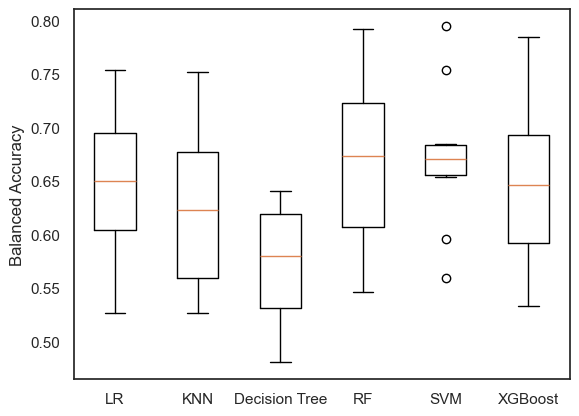

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

# List of continuous variables
numeric_var = [
    "resect_pt_age", #age
    "age_of_onset",
    "eo_days_postsurg",
    "eo_year_surg",
    "seizure_notes_word_cnt",
    "eeg",
    "engel_outcomes",
    "mri",
    "neuroanatomical_labeling",
    "neuropsychological_testing",
    "surgical_information",
    "freq_per_month",
    "date_diff_eeg",
    "date_diff_neuropsychological_testing",
    "date_diff_mri",
    "presurg_scan_age",
    "BA_pred"
]  # , "prev_aeds_num"


column_names = numeric_var + list(set(X_train.columns) - set(numeric_var))

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var), remainder=categorical_pipe
)

# Define models
models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

results = []

# Loop through models
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])

    # Create a stratified k-fold cross-validator
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Cross-validate using the pipeline
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kf, scoring="balanced_accuracy", n_jobs=-1
    )

    # Append cross-validation results to the results list
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())
plt.ylabel("Balanced Accuracy")
plt.show()

### Nested CV with hyperparameter tuning

In the following, I plotted the AUC score for a few models after preprocessing, feature selection and hyperparameter tuning.

The inner CV is for hyperparameter tuning while the outer CV is for scoring.

In [12]:
if False:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV, StratifiedKFold
    from sklearn.linear_model import ElasticNet
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_selection import SelectFromModel
    from sklearn.metrics import roc_auc_score
    from xgboost import XGBClassifier

    X_CV = X_train.copy()
    y_CV = y_train.copy()

    # Define model pipelines with named steps and feature selection
    model_pipelines = {
        "elasticnet": Pipeline(
            [
                ("preprocessor", preprocessor),
                ("feature_selection", SelectFromModel(ElasticNet(random_state=42))),
                ("model", ElasticNet()),
            ]
        ),
        "random_forest": Pipeline(
            [
                ("preprocessor", preprocessor),
                (
                    "feature_selection",
                    SelectFromModel(RandomForestClassifier(random_state=42)),
                ),
                ("model", RandomForestClassifier()),
            ]
        ),
        #'xgboost': Pipeline([
        #    ('preprocessor', preprocessor),
        #    ('feature_selection', SelectFromModel(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))),
        #    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
        # ])
        #'svm': Pipeline([
        #    ('preprocessor', preprocessor),
        #    ('feature_selection', SelectFromModel(SVC(kernel="linear", random_state=42))),
        #    ('model', SVC())
        # ])
    }

    # Define hyperparameter grids for each model
    models_and_parameters = {
        "elasticnet": {
            "feature_selection__estimator__alpha": np.linspace(0, 1, 5),
            "feature_selection__estimator__l1_ratio": np.linspace(0, 1, 5),
            "model__alpha": np.linspace(0, 1, 5),
            "model__l1_ratio": np.linspace(0, 1, 5),
        },
        "random_forest": {
            "feature_selection__estimator__n_estimators": np.linspace(5, 120, 5, dtype=int),
            "model__n_estimators": np.linspace(5, 100, 5, dtype=int),
            "model__max_depth": np.linspace(2, 10, 5, dtype=int),
        },
        #'xgboost': {'feature_selection__estimator__n_estimators': np.linspace(5, 120, 5, dtype=int),
        #            'model__n_estimators': np.linspace(5, 120, 5, dtype=int),
        #            'model__learning_rate': np.logspace(-3, -1, 3)}
        #'svm': {'feature_selection__estimator__C': np.logspace(-3, 2, 6),
        #        'model__C': np.logspace(-3, 2, 6),
        #        'model__kernel': ['linear', 'rbf', 'poly'],
        #        'model__gamma': ['scale', 'auto']}
    }

    # Perform nested cross-validation and store selected features
    outer_cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    inner_cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    results = {}
    selected_features = {}
    best_params = {}

    for model_name, pipeline in model_pipelines.items():
        param_grid = models_and_parameters[model_name]
        auc_scores = []
        features_selected = []
        params = []

        for train_idx, test_idx in outer_cv.split(X_CV, y_CV):
            X_train_fold, X_test_fold = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
            y_train_fold, y_test_fold = y_CV.iloc[train_idx], y_CV.iloc[test_idx]

            # Inner CV for hyperparameter tuning
            grid_search = GridSearchCV(
                pipeline, param_grid, cv=inner_cv, scoring="roc_auc", n_jobs=-1
            )
            grid_search.fit(X_train_fold, y_train_fold)

            # Best model and parameters
            best_model = grid_search.best_estimator_
            params.append(grid_search.best_params_)

            # Evaluate on test set
            y_pred = best_model.predict(X_test_fold)
            auc_score = roc_auc_score(y_test_fold, y_pred)
            auc_scores.append(auc_score)

        results[model_name] = auc_scores
        best_params[model_name] = params

    # Convert results to a DataFrame for easier plotting
    all_scores = pd.DataFrame(results)

    # Plot AUC scores
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=all_scores)
    plt.title("Model Comparison (AUC Scores)")
    plt.ylabel("AUC Score")
    plt.show()

In [13]:
if False:
    import statsmodels.api as sm

    # Using Statsmodels to calculate the mean and 95% confidence interval
    ci_low, ci_upp = sm.stats.DescrStatsW(all_scores["elasticnet"]).tconfint_mean()

    print("Mean:", all_scores["elasticnet"].mean())
    print("95% Confidence Interval:", (ci_low, ci_upp))

In [14]:
if False:
    import statsmodels.api as sm

    # Using Statsmodels to calculate the mean and 95% confidence interval
    ci_low, ci_upp = sm.stats.DescrStatsW(all_scores["random_forest"]).tconfint_mean()

    print("Mean:", all_scores["random_forest"].mean())
    print("95% Confidence Interval:", (ci_low, ci_upp))

# Logistic Regression model

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# List of continuous variables
numeric_var = [
    "resect_pt_age",
    "age_of_onset",
    "eo_days_postsurg",
    "eo_year_surg",
    "seizure_notes_word_cnt",
    "eeg",
    "engel_outcomes",
    "mri",
    "neuroanatomical_labeling",
    "neuropsychological_testing",
    "surgical_information",
    "freq_per_month",
    "date_diff_eeg",
    "date_diff_neuropsychological_testing",
    "date_diff_mri",
    "presurg_scan_age",
    "BA_pred"
]  # , "prev_aeds_num"

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var), remainder=categorical_pipe
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(
    X_train_processed, columns=preprocessor.get_feature_names_out()
)

X_test_processed = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(
    X_test_processed, columns=preprocessor.get_feature_names_out()
)

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Initialize LogisticRegressionCV
log_reg_cv = LogisticRegressionCV(
    l1_ratios=np.linspace(0, 1, 10),
    penalty="elasticnet",
    solver="saga",
    cv=cv,
    scoring="roc_auc",
    random_state=0,
    max_iter=10000,
    n_jobs=-1,
)

# Fit the model
log_reg_cv.fit(X_train_processed, y_train)

# Predict probabilities on the training set
y_train_pred_proba = log_reg_cv.predict_proba(X_train_processed)[:, 1]

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training AUC: {train_auc}")

# Coefficients plot
feature_names = X_train_processed.columns
coefficients = log_reg_cv.coef_.flatten()

Training AUC: 0.7496763137852247


# Elasticnet model

In [16]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold


# Define model pipelines with named steps and feature selection
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        # ('feature_selection', SelectFromModel(ElasticNet(random_state=42))),
        ("model", ElasticNet(max_iter=10000)),
    ]
)

param_grid = {  #'feature_selection__estimator__alpha': np.linspace(0, 1, 5),
    #'feature_selection__estimator__l1_ratio': np.linspace(0, 1, 5),
    "model__alpha": np.linspace(0, 1, 5),
    "model__l1_ratio": np.linspace(0, 1, 5),
}

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Inner CV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_


# Predict probabilities on the training set
y_train_pred = best_model.predict(X_train)

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred)
print(f"Training AUC: {train_auc}")

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {test_auc}")

c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


Training AUC: 0.8078255902513327
Test AUC: 0.6708898944193061


c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.932e+01, tolerance: 1.137e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [17]:
from sklearn.metrics import classification_report

y_test_pred = log_reg_cv.predict(X_test_processed)

print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

       False       0.55      0.65      0.60        43
        True       0.77      0.68      0.72        73

    accuracy                           0.67       116
   macro avg       0.66      0.67      0.66       116
weighted avg       0.69      0.67      0.68       116



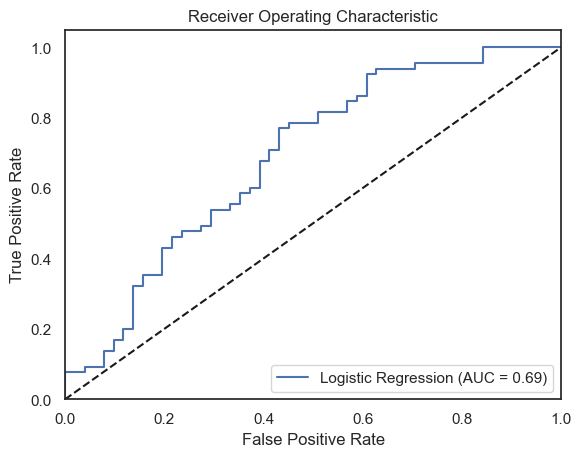

In [18]:
# Predict probabilities on the testing set
y_test_pred_proba = log_reg_cv.predict_proba(X_test_processed)[:, 1]

# Compute AUC score on the testing set
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (AUC = %0.2f)" % test_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [19]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


param_grid = {
    "n_estimators": np.linspace(5, 115, 15, dtype=int),
    "max_depth": np.linspace(2, 10, 10, dtype=int),
}

clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

clf_cv = GridSearchCV(clf, param_grid, cv=10, scoring="roc_auc", n_jobs=-1)

# Fit the model
clf_cv.fit(X_train_processed, y_train)

# Predict probabilities on the training set
y_train_pred_proba = clf_cv.predict_proba(X_train_processed)[:, 1]

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training AUC: {train_auc}")

Training AUC: 0.8425171363290175


In [20]:
from sklearn.metrics import classification_report

y_test_pred = clf_cv.predict(X_test_processed)

print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

       False       0.59      0.61      0.60        49
        True       0.71      0.69      0.70        67

    accuracy                           0.66       116
   macro avg       0.65      0.65      0.65       116
weighted avg       0.66      0.66      0.66       116



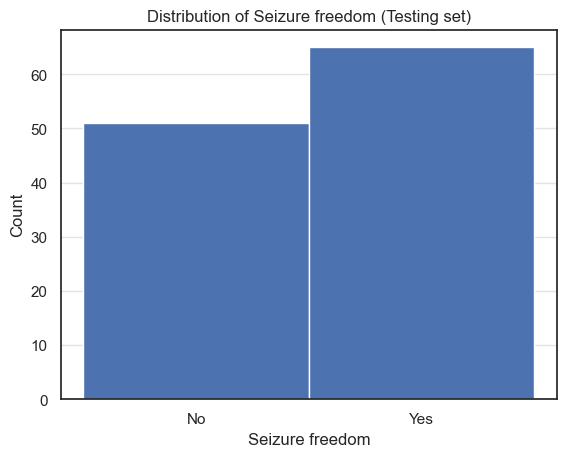

In [21]:
# Create a histogram of the 'surg_engel' variable
plt.hist(y_test + 1, bins=[1, 2, 3])  # Specify the bin edges

# Customize x-axis ticks and labels
bin_centers = [1.5, 2.5]
plt.xticks(bin_centers, ["No", "Yes"])

# Add labels and title
plt.xlabel("Seizure freedom")
plt.ylabel("Count")
plt.title("Distribution of Seizure freedom (Testing set)")

# Add grid for better readability
plt.grid(axis="y", alpha=0.55)

# Show the plot
plt.show()

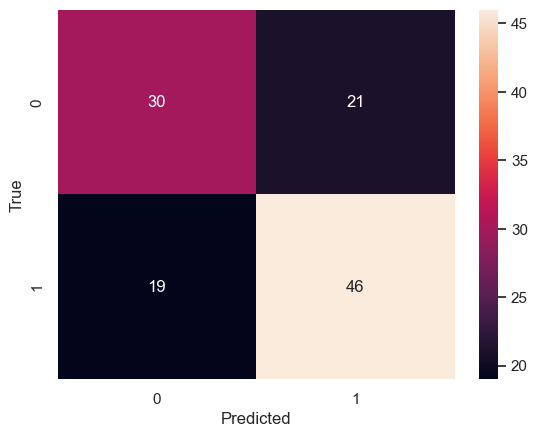

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [23]:
# Predict probabilities on the testing set
y_test_pred_proba = clf_cv.predict_proba(X_test_processed)[:, 1]

# Compute AUC score on the testing set
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Print AUC score on the testing set
print(f"Testing AUC: {test_auc}")

Testing AUC: 0.6723981900452488


In [24]:
# Update column names by removing "remainder__" and "pipeline__" prefixes
X_test_processed.columns = [
    col.replace("remainder__", "").replace("pipeline__", "")
    for col in X_test_processed.columns
]

## SHAP Values

We use SHAP values to determine the importance of the different variables and the direction of their effects.

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


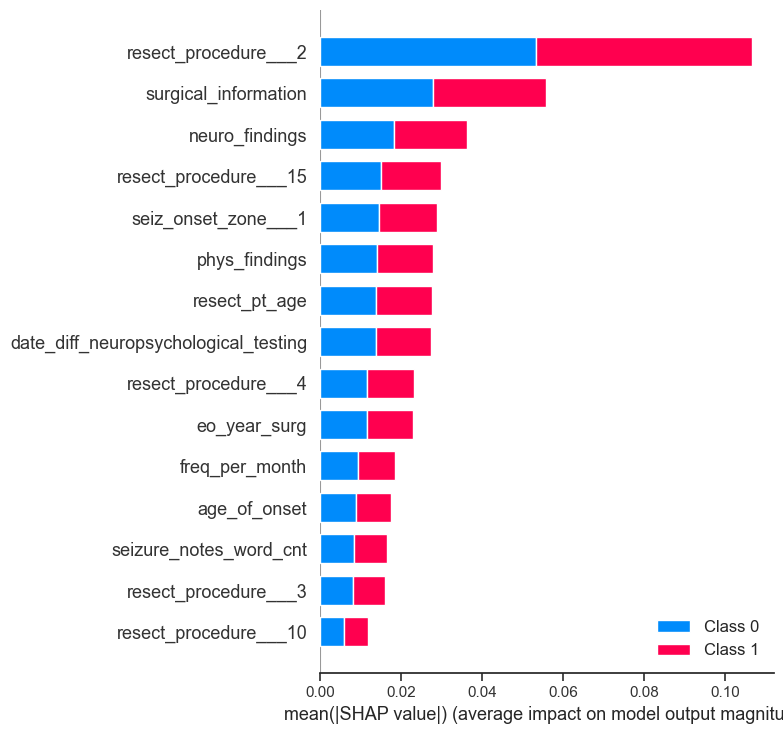

In [25]:
import shap

explainer = shap.TreeExplainer(clf_cv.best_estimator_)
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values, X_test_processed, max_display=15)

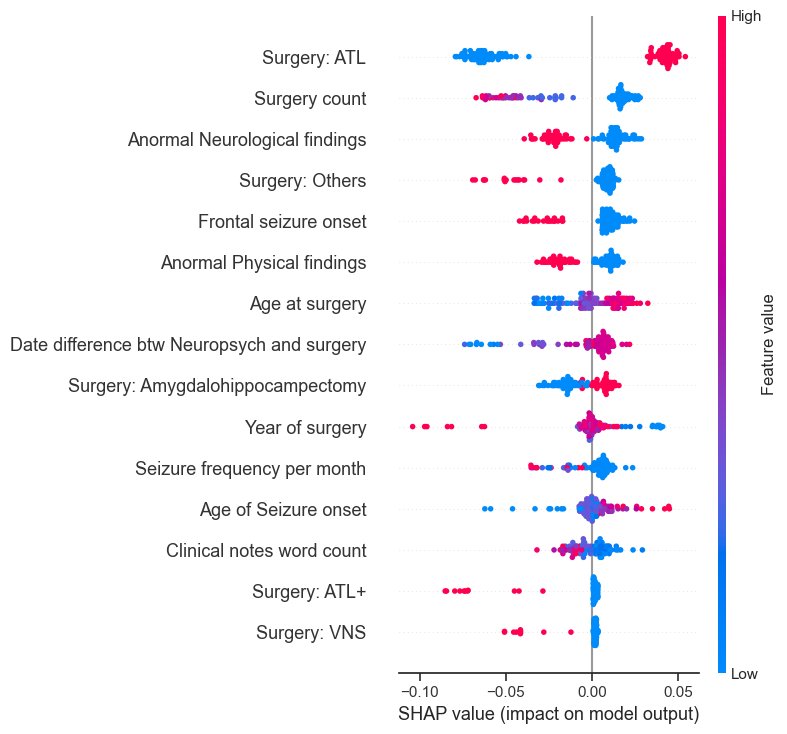

In [26]:
import shap

# Update column names by removing "remainder__" and "pipeline__" prefixes
X_test_processed.columns = [
    col.replace("remainder__", "").replace("pipeline__", "")
    for col in X_test_processed.columns
]

change_column_name = {
    "resect_procedure___2": "Surgery: ATL",
    "resect_procedure___3": "Surgery: ATL+",
    "resect_procedure___4": "Surgery: Amygdalohippocampectomy",
    "resect_procedure___5": "Surgery: Lesionectomy",
    "resect_procedure___10": "Surgery: VNS",
    "resect_procedure___15": "Surgery: Others",
    "surgical_information": "Surgery count",
    "seiz_onset_zone___1": "Frontal seizure onset",
    "age_of_onset": "Age of Seizure onset",
    "freq_per_month": "Seizure frequency per month",
    "age": "Age",
    "resect_pt_age": "Age at surgery",
    "BA_pred": "Predicted brain age",
    "eo_year_surg":"Year of surgery",
    "neuropsychological_testing": "Number of Neuropsych tests",
    "seizure_notes_word_cnt": "Clinical notes word count",
    "eo_days_postsurg": "Number of days post-surgery",
    "phys_findings": "Anormal Physical findings",
    "neuro_findings": "Anormal Neurological findings",
    "date_diff_neuropsychological_testing": "Date difference btw Neuropsych and surgery",
}

X_test_processed_name = X_test_processed.rename(columns=change_column_name)

explainer = shap.TreeExplainer(clf_cv.best_estimator_)
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values[1], X_test_processed_name, max_display=15)

## Reduce Number of Input variables

Here, we use the top features based on their SHAP values to train a new model.

In [27]:
import pandas as pd
import numpy as np

# 1. Calculate the mean absolute SHAP values for each feature
shap_sum = np.abs(shap_values[1]).mean(axis=0)
importance_df = pd.DataFrame([X_test_processed.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ["Feature Name", "SHAP Importance"]
importance_df["SHAP Importance"] = importance_df["SHAP Importance"].astype(float)

# 2. Sort the dataframe by SHAP Importance in descending order to get the top features
importance_df = importance_df.sort_values(
    "SHAP Importance", ascending=False
).reset_index(drop=True)

# 3. Select the top 20 features
top_features = importance_df.head(20)["Feature Name"].values
# top_features = np.array([feature.replace("remainder__", "").replace("pipeline__", "") for feature in top_features])

# Now, you can select only these top features from your dataset
X_train_selected = X_train[top_features]
X_test_selected = X_test_processed[top_features]

In [28]:
# Get the list of column names
# column_names = X_train_processed.columns.tolist()
# column_names = [name.replace("remainder__", "").replace("pipeline__", "") for name in column_names]

# Now you can save it to a file or use it as needed. For example, saving to a text file:
with open("../../data/processed/column_names_test.txt", "w") as file:
    for feature in top_features:
        file.write(feature + "\n")

# Or, you can save it as a CSV file without index:
pd.Series(column_names).to_csv("../../data/processed/column_names_test.csv", index=False)

In [29]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

# List of continuous variables
numeric_var = [
    "resect_pt_age",
    "age_of_onset",
    "eo_days_postsurg",
    "eo_year_surg",
    "seizure_notes_word_cnt",
    "eeg",
    "engel_outcomes",
    "mri",
    "neuroanatomical_labeling",
    "neuropsychological_testing",
    "surgical_information",
    "freq_per_month",
    "date_diff_eeg",
    "date_diff_neuropsychological_testing",
    "date_diff_mri",
    "presurg_scan_age",
    "BA_pred"
]  # , "prev_aeds_num"

# Filter the list to keep only those variables that are columns in X_train_selected
numeric_var_selected = [var for var in numeric_var if var in X_train_selected.columns]

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var_selected), remainder=categorical_pipe
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train_selected)
X_train_processed = pd.DataFrame(
    X_train_processed, columns=preprocessor.get_feature_names_out()
)

X_test_processed = preprocessor.transform(X_test_selected)
X_test_processed = pd.DataFrame(
    X_test_processed, columns=preprocessor.get_feature_names_out()
)

param_grid = {
    "n_estimators": np.linspace(5, 115, 15, dtype=int),
    "max_depth": np.linspace(2, 10, 10, dtype=int),
}

clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

clf_cv = GridSearchCV(clf, param_grid, cv=10, scoring="roc_auc", n_jobs=-1)

# Fit the model
clf_cv.fit(X_train_processed, y_train)

# Predict probabilities on the training set
y_train_pred_proba = clf_cv.predict_proba(X_train_processed)[:, 1]

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training AUC: {train_auc}")

Training AUC: 0.8098819497334349


In [30]:
# Predict probabilities on the testing set
y_test_pred_proba = clf_cv.predict_proba(X_test_processed)[:, 1]

# Compute AUC score on the testing set
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Print AUC score on the testing set
print(f"Testing AUC: {test_auc}")

Testing AUC: 0.6785822021116138


In [31]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# Initialize lists to store the results
num_features_list = []
auc_scores_list = []

# Make a copy of the full feature set and SHAP importance dataframe
remaining_features = top_features.copy()
importance_df_20 = importance_df.head(20)
importance_df_temp = importance_df_20.copy()


for i in range(len(top_features)):
    # Update column names by removing "remainder__" and "pipeline__" prefixes
    X_train_processed.columns = [
        col.replace("remainder__", "").replace("pipeline__", "")
        for col in X_train_processed.columns
    ]
    X_test_processed.columns = [
        col.replace("remainder__", "").replace("pipeline__", "")
        for col in X_test_processed.columns
    ]

    # Select the current set of features
    X_train_selected = X_train_processed[remaining_features]
    X_test_selected = X_test_processed[remaining_features]

    # List of continuous variables
    numeric_var = [
        "resect_pt_age",
        "age_of_onset",
        "eo_days_postsurg",
        "eo_year_surg",
        "seizure_notes_word_cnt",
        "eeg",
        "engel_outcomes",
        "mri",
        "neuroanatomical_labeling",
        "neuropsychological_testing",
        "surgical_information",
        "freq_per_month",
        "date_diff_eeg",
        "date_diff_neuropsychological_testing",
        "date_diff_mri",
        "presurg_scan_age",
        "BA_pred"
    ]  # , "prev_aeds_num"

    # Filter the list to keep only those variables that are columns in X_train_selected
    numeric_var_selected = [
        var for var in numeric_var if var in X_train_selected.columns
    ]

    # Define preprocessing pipelines
    numeric_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
    categorical_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"))

    # Define the preprocessing pipeline
    preprocessor = make_column_transformer(
        (numeric_pipe, numeric_var_selected), remainder=categorical_pipe
    )

    # Apply preprocessing
    X_train_processed = preprocessor.fit_transform(X_train_selected)
    X_train_processed = pd.DataFrame(
        X_train_processed, columns=preprocessor.get_feature_names_out()
    )

    X_test_processed = preprocessor.transform(X_test_selected)
    X_test_processed = pd.DataFrame(
        X_test_processed, columns=preprocessor.get_feature_names_out()
    )

    # Retrain the model with the current set of features
    clf_cv.fit(X_train_processed, y_train)

    # Update column names by removing "remainder__" and "pipeline__" prefixes
    # X_train_selected.columns = ['pipeline__' + col for col in X_train_selected.columns]

    # Predict probabilities and compute AUC score
    y_train_pred_proba = clf_cv.predict_proba(X_train_processed)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_pred_proba)

    # Store the number of features and the corresponding AUC score
    num_features_list.append(len(remaining_features))
    auc_scores_list.append(train_auc)

    # Print the current number of features and AUC score for tracking progress
    print(f"Number of features: {len(remaining_features)}, Training AUC: {train_auc}")

    if len(remaining_features) > 1:
        # Remove the feature with the lowest SHAP value
        least_important_feature = importance_df_temp.iloc[-1]["Feature Name"]
        remaining_features = remaining_features[
            remaining_features != least_important_feature
        ]
        importance_df_temp = importance_df_temp[:-1]

    else:
        # If there's only one feature left, end the loop
        break

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, auc_scores_list, marker="o")
plt.gca().invert_xaxis()  # Optional: Invert the x-axis to show decreasing number of features
plt.title("AUC Score vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("AUC Score")
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
import pickle

with open("../../data/processed/auc_scores_list", "wb") as fp:  # Pickling
    pickle.dump(filtered_data, fp)

NameError: name 'filtered_data' is not defined

In [ ]:
# filtered_data = test[0::2]

In [ ]:
import pickle

with open("../../data/processed/auc_scores_list", "rb") as fp:  # Unpickling
    test = pickle.load(fp)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Create a new reversed version of the data
data = test[::-1]

# Initialize lists to store mean, CI lower bound, and CI upper bound
means = []
ci_lowers = []
ci_uppers = []

# Calculate mean and 95% CI for each set of AUC values
for auc_values in data:
    mean_auc = np.mean(auc_values)
    sem = stats.sem(auc_values)
    ci = stats.t.interval(0.95, len(auc_values) - 1, loc=mean_auc, scale=sem)

    # Store results
    means.append(mean_auc)
    ci_lowers.append(ci[0])
    ci_uppers.append(ci[1])

# Create x values for the number of variables in the model
x_values = range(1, 21)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, means, label="Mean AUC", color="b")
plt.fill_between(x_values, ci_lowers, ci_uppers, color="b", alpha=0.2, label="95% CI")
plt.title("AUC by Number of Variables in the Model")
plt.xlabel("Number of Variables")
plt.ylabel("AUC")
plt.xticks(x_values)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_train = y_train.reset_index(drop=True)
df = X_train_processed.join(y_train, how="outer")

In [ ]:
def create_surg_group(nbr_surg):
    if nbr_surg == 1:
        return "Group 1"
    elif nbr_surg == 2:
        return "Group 2"
    else:
        return "Group 3"


def convert_columns_to_boolean(df, numeric_vars):
    for col in df.columns:
        if col not in numeric_vars:
            df[col] = df[col].astype(bool)
    return df

In [ ]:
import pandas as pd
from statsmodels.regression.mixed_linear_model import MixedLM

# List of continuous and non-continuous variables
numeric_var = [
    "age",
    "age_of_onset",
    "eo_yrs_postsurg",
    "eo_year_surg",
    "seizure_notes_word_cnt",
    "eeg",
    "engel_outcomes",
    "mri",
    "neuroanatomical_labeling",
    "neuropsychological_testing",
    "surgical_information",
    "freq_per_month",
]  # , "prev_aeds_num"

# Variables in X_CV but not in numeric_var are treated as categorical
categorical_var = [
    col for col in X_train.columns if col not in numeric_var and col != "y"
]


# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy="median"))
categorical_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var), remainder=categorical_pipe
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(
    X_train_processed, columns=preprocessor.get_feature_names_out()
)

X_test_processed = preprocessor.fit_transform(X_test)
X_test_processed = pd.DataFrame(
    X_test_processed, columns=preprocessor.get_feature_names_out()
)

# Clean column names by removing 'pipeline__' and 'remainder__'
X_train_processed.columns = [
    col.replace("pipeline__", "").replace("remainder__", "")
    for col in X_train_processed.columns
]
X_test_processed.columns = [
    col.replace("pipeline__", "").replace("remainder__", "")
    for col in X_test_processed.columns
]

# Convert non-numeric columns to boolean in both X_train and X_test
X_train = convert_columns_to_boolean(X_train_processed, numeric_var)
X_test = convert_columns_to_boolean(X_test_processed, numeric_var)


X_train_processed["surgical_group"] = (
    X_train_processed["surgical_information"]
    .apply(create_surg_group)
    .astype("category")
)

# Ensure your DataFrame (X_CV) includes the target variable y_CV
X_train_processed["surg_engel"] = y_train.copy()

# Construct the formula
# formula_parts = [f"C(Q('{var}'))" for var in categorical_var]
# formula_parts = [f"Q('{var}')" for var in numeric_var]
# formula = 'y ~ ' + ' + '.join(formula_parts)

formula = """surg_engel ~ age + age_of_onset + eo_yrs_postsurg + eo_year_surg + freq_per_month + 
C(sex_gender) + C(resect_procedure___2) + C(neuro_findings) + 
C(seiz_onset_zone___1) + eeg + 
neuropsychological_testing + phys_findings + C(seizure_class___2) + 
mri""".replace(
    "\n", ""
)

# Define the model
groups_var = "surgical_group"  # Random effects variable

model = MixedLM.from_formula(formula, groups=groups_var, data=X_train_processed)
result = model.fit()
print(result.summary())

In [ ]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for the positive class
y_pred_prob = result.predict(X_test_processed)  # Make sure this returns probabilities

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)

print(f"AUC: {auc}")

## Null accuracy

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier that always predicts the most frequent class
dummy_classifier = DummyClassifier(strategy="most_frequent")

# Fit the DummyClassifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the training data
y_pred_dummy = dummy_classifier.predict(X_train)

# Calculate null accuracy
null_accuracy = accuracy_score(y_train, y_pred_dummy)

print(f"Null Accuracy: {null_accuracy:.2f}")

## Print system information

In [ ]:
import session_info

session_info.show()